In [ ]:
import random
import string
import numpy as np

import torch
import torch.nn.functional as F
from torch import Tensor

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from dataclasses import dataclass, field

torch.set_printoptions(linewidth=120)
seed = 42  # 2**31 - 1

torch.manual_seed(seed)

<hr>

# Wavenet
<hr>

In our previous notebook, we successfully implemented a Multi-Layer Perceptron (MLP) character-level language model. This model was designed to predict the fourth character in a sequence based on three preceding characters, utilizing only a single hidden layer.

In this notebook, we aim to enhance the complexity of our architecture. Specifically, we intend to expand the input sequence by incorporating more characters. Additionally, we aim to address the limitation of the previous model where a single hidden layer compressed a significant amount of information too quickly. Instead, we will develop a deeper model that progressively integrates this information to make more accurate predictions regarding the next character in the sequence.

To accomplish this, we will adopt an approach similar to that of a [WaveNet](https://arxiv.org/pdf/1609.03499.pdf), as described in the research paper published by DeepMind in 2016. While WaveNet primarily focuses on predicting audio sequences rather than character or word-level sequences, the fundamental model structure remains analogous. It operates as an autoregressive model, predicting the subsequent character in a sequence. Notably, the architecture employs a hierarchical framework, resembling a tree-like structure, to effectively forecast the next character.

```{figure} ./media/wavenet2.png
:width: 400px
:name: MLP

Wavenet (van den Oord et al. 2016)
```





## Setup

**Load the data**

In [2]:
# Load the data
with open("./data/names.txt", "r") as f:
    names = f.read().splitlines()
print(f"Total # names: {len(names):.>25,}")
print(f"Total # characters in all names: {len(''.join(names)):,}")
print(names[:5])

Total # names: ...................32,033
Total # characters in all names: 196,113
['emma', 'olivia', 'ava', 'isabella', 'sophia']


**Encoding and decoding characters**   
We define an encoder `ch2ix` and decoder `ix2ch` function that maps a character with a numerical representation (i.e. a unique integer) and vice-versa. 

In [3]:
chars = "." + string.ascii_lowercase
ch2ix = {s: i for i, s in enumerate(chars)}
ix2ch = {i: s for s, i in ch2ix.items()}

print("Encoder ch2ix:\n", ch2ix)
print("Decoder ix2ch:\n", ix2ch)
print("E.g. emma:", [ch2ix[c] for c in ".emma."])

vocab_size = len(chars)
print(f"\nVocab size: {vocab_size:,}")

Encoder ch2ix:
 {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
Decoder ix2ch:
 {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
E.g. emma: [0, 5, 13, 13, 1, 0]

Vocab size: 27


**Dataset**

In [4]:
@dataclass
class Dataset:
    """
    Attributes:
    names: list of names.
    block_size: context length: how many characters do we take to predict the next one?
    """

    names: list[str]
    block_size: int = 3
    verbose: bool = False
    X: Tensor = field(init=False)
    Y: Tensor = field(init=False)

    def __post_init__(self) -> None:
        self._make_dataset()

    def _make_dataset(self) -> None:
        X, Y = [], []
        for w in self.names:
            if self.verbose:
                print(w)
            context = [0] * self.block_size
            for ch in w + ".":
                ix = ch2ix[ch]
                X.append(context)
                Y.append(ix)
                if self.verbose:
                    print("".join(ix2ch[i] for i in context), "--->", ix2ch[ix])
                context = context[1:] + [ix]  # crop and append
        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y)

**Create a training, validation and test set**

In [5]:
# Create a training, validation and test set
block_size = 3
np.random.seed(seed)
np.random.shuffle(names)

n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

ds_tr = Dataset(names[:n1], block_size=block_size)
Xtr, Ytr = ds_tr.X, ds_tr.Y  # 80%
ds_val = Dataset(names[n1:n2], block_size=block_size)
Xval, Yval = ds_val.X, ds_val.Y  # 10%
ds_te = Dataset(names[n2:], block_size=block_size)
Xte, Yte = ds_te.X, ds_te.Y  # 10%

print(f"Training set: {len(ds_tr.names):.>25,} names")
print(f"Validation set: {len(ds_val.names):.>23,} names")
print(f"Test set: {len(ds_te.names):.>29,} names")
print()
print(f"Training set: {len(Xtr):.>25,} 3-char samples")
print(f"Validation set: {len(Xval):.>23,} 3-char samples")
print(f"Test set: {len(Xte):.>29,} 3-char samples")

Training set: ...................25,626 names
Validation set: ..................3,203 names
Test set: ........................3,204 names

Training set: ..................182,671 3-char samples
Validation set: .................22,784 3-char samples
Test set: .......................22,691 3-char samples


## Modules

We manually define the following modules, mimicking the [PyTorch API](https://pytorch.org/docs/stable/nn.html): 
- Linear
- BatchNorm1d
- Tanh
- Flatten
- Sequential

### Linear

[`torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)

Applies a linear transformation to the incoming data: $y=xA^T+b$

In [6]:
class Linear:
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        seed: int | None = None,
    ) -> None:
        g = torch.Generator().manual_seed(seed) if seed else None
        self.use_bias = bias
        self.weight = torch.randn((in_features, out_features), generator=g)
        self.bias = torch.zeros(out_features) if bias else None

    def __call__(self, x: Tensor) -> Tensor:
        x = x @ self.weight
        if self.use_bias:
            x += self.bias
        self.out = x  # To be able to access x for plotting
        return self.out

    def parameters(self) -> list:
        return [self.weight] + ([self.bias] if self.use_bias else [])

### BatchNorm1d

[`torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d)

Applies Batch Normalization over a 2D or 3D input as described in the paper Batch Normalization: [Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167).

$y=\Large{\frac{x-\mathrm{E}[x]}{\sqrt{\mathrm{Var}[x]+\epsilon}}}\normalsize{*\gamma+\beta}$  

```{note}
The running mean and standard deviation are not computed by backpropagation, but rather by an exponential moving average in the forward pass.   

It is important to note that the behavior of batch normalization differs between training and evaluation phases. By utilizing the is_train parameter, we can appropriately configure the module to operate in the desired state for each phase.

Batches are typically utilized for efficiency purposes but batchorm introduces a coupling effect among the activations across the batch. 
```





In [7]:
class BatchNorm1d:
    def __init__(
        self, num_features: int, eps: float = 1e-5, momentum: float = 0.1, is_train=True
    ) -> None:
        self.eps = eps
        self.momentum = momentum
        self.is_train = is_train
        # Trainable parameters
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        # Running stats trained with 'momentum update'
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

    def __call__(self, x: Tensor) -> Tensor:
        if self.is_train:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var

        x = (x - x_mean) / torch.sqrt(x_var + self.eps)
        x = self.gamma * x + self.beta

        # Update running stats
        if self.is_train:
            self.running_mean = (
                1 - self.momentum
            ) * self.running_mean + self.momentum * x_mean
            self.running_var = (
                1 - self.momentum
            ) * self.running_var + self.momentum * x_var

        self.out = x  # To be able to access x for plotting
        return self.out

    def parameters(self) -> list[Tensor]:
        return [self.gamma, self.beta]

### Tanh

[torch.nn.Tanh()](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

Applies the element-wise function: $\tanh(x)=\large\frac{e^x-e^{-x}}{e^x+e^{-x}}$

```{figure} ./media/tanh.png
:width: 200px
:name: MLP


In [8]:
class Tanh:
    def __call__(self, x) -> Tensor:
        x = torch.tanh(x)
        self.out = x  # To be able to access x for plotting
        return self.out

    def parameters(self) -> list:
        return []

### Embedding

[`torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2.0, scale_grad_by_freq=False, sparse=False, _weight=None, device=None, dtype=None)`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding)

A simple lookup table that stores embeddings of a fixed dictionary and size. The input to the module is a list of indices, and the output is the corresponding embedding.


In [9]:
class Embedding:
    def __init__(
        self, num_embeddings: int, embedding_dim: int, seed: int | None = None
    ) -> None:
        g = torch.Generator().manual_seed(seed) if seed else None
        self.weight = torch.randn((num_embeddings, embedding_dim), generator=g)

    def __call__(self, IX: Tensor) -> Tensor:
        self.out = self.weight[IX]
        return self.out

    def parameters(self) -> list:
        return [self.weight]

### Flatten

[`torch.flatten(input, start_dim=0, end_dim=-1)`](https://pytorch.org/docs/stable/generated/torch.flatten.html#torch.flatten)

Flattens a contiguous range of dims into a tensor.

In [10]:
class Flatten:
    def __init__(self) -> None:
        self.out: Tensor

    def __call__(self, x: Tensor) -> Tensor:
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self) -> list:
        return []

### Sequential

[`torch.nn.Sequential()`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)

A sequential container. Modules will be added to it in the order they are passed in the constructor.

In [11]:
class Sequential:
    def __init__(self, layers) -> None:
        self.layers = layers

    def __call__(self, x: Tensor) -> Tensor:
        for layer in self.layers:
            x = layer(x)
            self.out = x  # To be able to access x for plotting
        return self.out

    def parameters(self) -> list:
        return [p for layer in self.layers for p in layer.parameters()]

## MLP Model

In [12]:
n_emb = 10  # Dimensionality of the character embedding
n_hidden = 200  # Number of neurons in the hidden layer

model = Sequential(
    [
        Embedding(vocab_size, n_emb),  # 27 x 10
        Flatten(),
        Linear(block_size * n_emb, n_hidden, bias=False),  # 30 x 200
        BatchNorm1d(n_hidden),  # 100
        Tanh(),
        Linear(n_hidden, vocab_size),  # 100 x 27
    ]
)

# Parameter initialization
with torch.no_grad():
    model.layers[-1].weight *= 0.1  # type: ignore # make the output layer less confident

parameters = model.parameters()
print(f"Number of parameters: {sum(p.numel() for p in parameters):,}")

for p in parameters:
    p.requires_grad = True

Number of parameters: 12,097


### Training

In [13]:
max_steps = 200000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (bs,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    logits = model(Xb)  # 32 x 27
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad  # type: ignore

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.5384
  10000/ 200000: 2.2268
  20000/ 200000: 2.0559
  30000/ 200000: 2.2531
  40000/ 200000: 2.4188
  50000/ 200000: 2.3597
  60000/ 200000: 1.7257
  70000/ 200000: 2.4970
  80000/ 200000: 2.1380
  90000/ 200000: 2.3107
 100000/ 200000: 2.3609
 110000/ 200000: 2.5647
 120000/ 200000: 2.3837
 130000/ 200000: 2.1681
 140000/ 200000: 2.1974
 150000/ 200000: 1.9655
 160000/ 200000: 2.2660
 170000/ 200000: 1.8958
 180000/ 200000: 1.8733
 190000/ 200000: 2.0807


**Plot average loss**

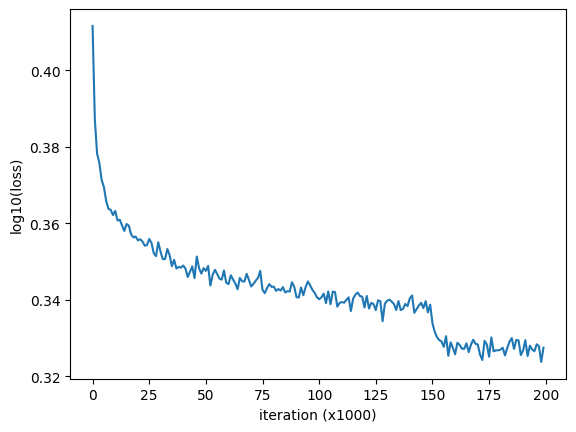

In [14]:
loss = torch.tensor(lossi).view(-1, 1000).mean(1)
plt.plot(loss)
plt.xlabel("iteration (x1000)")
plt.ylabel("log10(loss)")
plt.show()

At iteration 150k we observe that the learning rate decay subtracts a lot of energy out of the system and allows the model to settle into a local minimum. 

### Evaluation

**Putting the model in evaluation mode**

In [15]:
for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.is_train = False  # type: ignore


**Evaluate the loss**

In [16]:
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split) -> None:
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xval, Yval),
        "test": (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.1027722358703613
val 2.122612714767456


The difference between the training and validation loss is quite small. This indicates that the model is not overfitting to the training data. Therefore, we can expect better results when we make our model deeper and more larger.

**Sample from the model**

In [17]:
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    name = "".join(ix2ch[i] for i in out)
    print(f"exist: {name in names}  - {name:16s}")

exist: False  - damiara.        
exist: False  - alkzani.        
exist: False  - hadrian.        
exist: False  - freslyn.        
exist: False  - safia.          
exist: False  - ceir.           
exist: False  - jastielle.      
exist: False  - catine.         
exist: False  - aibun.          
exist: False  - denthira.       
exist: False  - lizi.           
exist: False  - jah.            
exist: False  - granie.         
exist: False  - dayson.         
exist: False  - amark.          
exist: False  - ben.            
exist: False  - quan.           
exist: False  - tori.           
exist: False  - makyia.         
exist: False  - cer.            


### Bigger block_size

We can increase the block_size to 8 and evaluate the model again.

Training set: ...................25,626 names
Validation set: ..................3,203 names
Test set: ........................3,204 names

Training set: ..................182,470 8-char samples
Validation set: .................22,738 8-char samples
Test set: .......................22,938 8-char samples

Number of parameters: 22,097
      0/ 200000: 3.1635
  10000/ 200000: 2.1102
  20000/ 200000: 2.2682
  30000/ 200000: 2.1871
  40000/ 200000: 2.0643
  50000/ 200000: 2.1722
  60000/ 200000: 2.2797
  70000/ 200000: 2.1995
  80000/ 200000: 1.6497
  90000/ 200000: 2.0141
 100000/ 200000: 2.0081
 110000/ 200000: 2.1394
 120000/ 200000: 1.8454
 130000/ 200000: 2.6146
 140000/ 200000: 2.2694
 150000/ 200000: 2.1428
 160000/ 200000: 1.6267
 170000/ 200000: 2.1457
 180000/ 200000: 1.8873
 190000/ 200000: 2.2060


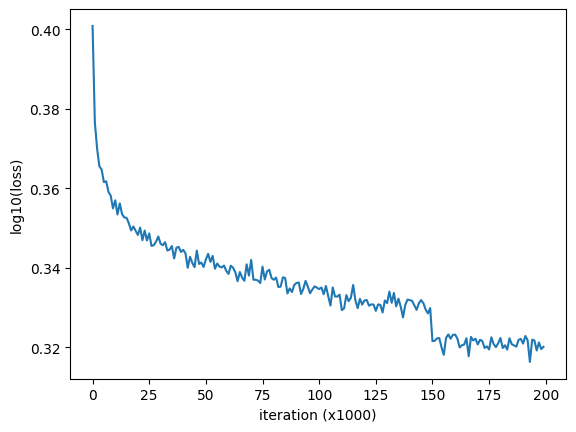

train 2.0719966888427734
val 2.1078131198883057
exist: False  - narir.          
exist: False  - lille.          
exist: False  - eliya.          
exist: False  - layella.        
exist: False  - hionna.         
exist: False  - jenzari.        
exist: False  - yatryn.         
exist: False  - yana.           
exist: False  - eliana.         
exist: False  - bessley.        
exist: False  - nhaytia.        
exist: False  - judal.          
exist: False  - keigh.          
exist: False  - averi.          
exist: False  - osetani.        
exist: False  - annajaly.       
exist: False  - kory.           
exist: False  - jasrib.         
exist: False  - jueley.         
exist: False  - linnaly.        


In [18]:
# Create a training, validation and test set
block_size = 8
np.random.seed(seed)
np.random.shuffle(names)

n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

ds_tr = Dataset(names[:n1], block_size=block_size)
Xtr, Ytr = ds_tr.X, ds_tr.Y  # 80%
ds_val = Dataset(names[n1:n2], block_size=block_size)
Xval, Yval = ds_val.X, ds_val.Y  # 10%
ds_te = Dataset(names[n2:], block_size=block_size)
Xte, Yte = ds_te.X, ds_te.Y  # 10%

print(f"Training set: {len(ds_tr.names):.>25,} names")
print(f"Validation set: {len(ds_val.names):.>23,} names")
print(f"Test set: {len(ds_te.names):.>29,} names")
print()
print(f"Training set: {len(Xtr):.>25,} {block_size}-char samples")
print(f"Validation set: {len(Xval):.>23,} {block_size}-char samples")
print(f"Test set: {len(Xte):.>29,} {block_size}-char samples")
# ------------------------------------------------------------

# MLP model
n_emb = 10  # Dimensionality of the character embedding
n_hidden = 200  # Number of neurons in the hidden layer

model = Sequential(
    [
        Embedding(vocab_size, n_emb),  # 27 x 10
        Flatten(),
        Linear(block_size * n_emb, n_hidden, bias=False),  # 80 x 200
        BatchNorm1d(n_hidden),  # 100
        Tanh(),
        Linear(n_hidden, vocab_size),  # 100 x 27
    ]
)
# ------------------------------------------------------------

# Parameter initialization
with torch.no_grad():
    model.layers[-1].weight *= 0.1  # type: ignore # make the output layer less confident

parameters = model.parameters()
print(f"\nNumber of parameters: {sum(p.numel() for p in parameters):,}")

for p in parameters:
    p.requires_grad = True
# ------------------------------------------------------------

# Training loop
max_steps = 200000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (bs,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    logits = model(Xb)  # 32 x 27
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad  # type: ignore

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
# ------------------------------------------------------------

# Plot average loss
loss = torch.tensor(lossi).view(-1, 1000).mean(1)
plt.plot(loss)
plt.xlabel("iteration (x1000)")
plt.ylabel("log10(loss)")
plt.show()
# ------------------------------------------------------------

# Put the model in evaluation mode\
for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.is_train = False  # type: ignore
# ------------------------------------------------------------


# Evaluate the model
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split) -> None:
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xval, Yval),
        "test": (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")
# ------------------------------------------------------------

# Generate some names
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    name = "".join(ix2ch[i] for i in out)
    print(f"exist: {name in names}  - {name:16s}")

The number of parameters have increased from 12.097 to 22.097 ((8-3)*10*200). The training loss has decreased from 2.103 to 2.072 and the validation loss has decreased from 2.123 to 2.108.

**Performance log**
- original (3 char context + 200 hidden neurons, 12K parameters): 2.103 train loss, 2.123 val loss
- context 3->8 char (22K parameters): 2.072 train loss, 2.108 val loss


## Wavenet Model

The problem with the MLP model is that we are crushing all the information into a single vector from the beginning. Even if we make the model deeper, we will still have the same problem. 

We can solve this by using a hierarchical approach like in Wavenet. In that architecture, the input is cruched slowly. In particular we take two characters and fuse them into a bi-gram representation. Then we take these bi-grams and fuse them into a 4-gram representation. We continue this process until we have a representation of the entire sequence. By using this tree-like hierarchical approach, we fuse the information from the previous context slowly.


```{figure} ./media/wavenet2.png
:width: 400px
:name: Wavenet

Wavenet (van den Oord et al. 2016)
```


In Pytorch when we can multiply a n-dimentional tensor with a 2-dimentional weight matrix. The result is a tensor with the same number of dimensions as the input tensor, except for the last dimension which is equal to the number of columns of the weight matrix. The matrix multiplication `@` only works on the last dimension of the input tensor. The other dimensions are left unchanged. 

In [19]:
x = torch.randn(2, 3, 4, 5)
W = torch.randn(5, 6)
b = torch.randn(6)
y = x @ W + b
y.shape

torch.Size([2, 3, 4, 6])

In our Wavenet model, we will have 8 characters comming in like this: 1, 2, 3, 4, 5, 6, 7, 8. In contrast with the previous MLP model, we don't want to flatten all of them into a single vector. Instead, we want to fuse them into a bi-gram representation. We want to group them like this: (1, 2), (3, 4), (5, 6), (7, 8). We can do this by reshaping the input tensor. 
We then want each of these bi-grams to be multiplied by a weight matrix in parallel.


In [20]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y
print(f"Xb.shape: {Xb.shape}")
print(f"Xb:\n{Xb}")


Xb.shape: torch.Size([4, 8])
Xb:
tensor([[ 0,  0,  0,  0, 10,  1, 14,  9],
        [ 0,  0,  0,  0,  0,  0,  0,  2],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  1,  1, 18,  9,  1, 14]])


In [21]:
logits = model(Xb)  # 4 x 27
print(f"MLP embedding output shape: {model.layers[0].out.shape}")
print(f"MLP flatten output shape: {model.layers[1].out.shape}")
print(f"MLP linear output shape: {model.layers[2].out.shape}")


MLP embedding output shape: torch.Size([4, 8, 10])
MLP flatten output shape: torch.Size([4, 80])
MLP linear output shape: torch.Size([4, 200])


We don't want the flatten layer to output a 4 x 80 tensor. Instead, we want it to output a 4 x 4 x 20 tensor. The first 4 is our batch dimention, the second 4 is the number of bi-grams and the last 20 is the size of the concatenated bi-gram embeddings.   
We have to change the flatten layer to output a 4 x 4 x 20 tensor and the linear layer to accept it as input. 

In [22]:
emb = torch.randn(4, 8, 10)  # 4 x 8 x 10

We want to create a 4 x 4 x 20 tensor where the consecutive pairs of 10-dim embedding vectors are concatenated. We can do this in two ways:

In [23]:
%%timeit
# 1st method
emb_even = emb[:, ::2, :] # 4 x 4 x 10
emb_odd = emb[:, 1::2, :] # 4 x 4 x 10
torch.cat([emb_even, emb_odd], dim=2) # 4 x 4 x 20

28.4 µs ± 170 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
%%timeit
# 2nd method
emb.view(4, 4, 20) # 4 x 4 x 20

3.54 µs ± 220 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Wavenet implementation

We will now implement the Wavenet like in the diagram, with folowing changes:
- The block_size is 8 instead of 16.
- The number of hidden layers is 3 instead of 4.


We first need to modify the `Flatten` module. 

In [25]:
class FlattenConsecutive:
    def __init__(self, n) -> None:
        self.n = n
        self.out: Tensor

    def __call__(self, x: Tensor) -> Tensor:
        B, L, C = x.shape  # batch, sequence length, channels
        x = x.view(B, L // self.n, C * self.n)
        if x.shape[1] == 1:  # all consecutive chars
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self) -> list:
        return []


We also need to modify the `BatchNorm1d` module.   
The calculations in the current implementation are as follows:

In [26]:
x = torch.randn(32, 4, 68)  # 32 x 4 x 68
x_mean = x.mean(0, keepdim=True)  # 1 x 4 x 68
x_var = x.var(0, keepdim=True)  # 1 x 4 x 68
x_hat = (x - x_mean) / torch.sqrt(x_var + 1e-5)  # 32 x 4 x 68
print(f"mean shape: {x_mean.shape}")
print(f"running mean shape: {model.layers[3].running_mean.shape}")  # type: ignore


mean shape: torch.Size([1, 4, 68])
running mean shape: torch.Size([1, 200])


The mean, var, running_mean and running_var are calculated only over the 1st dimension. Their shape is 1 x 4 x 68 which is not correct! We are maintaining statistics for every one of the 4 blocks of 68 channels individualy and independently. To correct this we need to calculate the statistics over the 1st and 2nd dimension. Their shape should be 1 x 1 x 68.

We will now modify the `BatchNorm1d` module to accept 2d or 3d tensors.

In [27]:
class BatchNorm1d:
    def __init__(
        self, num_features: int, eps: float = 1e-5, momentum: float = 0.1, is_train=True
    ) -> None:
        self.eps = eps
        self.momentum = momentum
        self.is_train = is_train
        # Trainable parameters
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        # Running stats trained with 'momentum update'
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

    def __call__(self, x: Tensor) -> Tensor:
        if self.is_train:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            else:
                raise ValueError(f"Unsupported tensor shape: {x.shape}")
            x_mean = x.mean(dim, keepdim=True)
            x_var = x.var(dim, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var

        x = (x - x_mean) / torch.sqrt(x_var + self.eps)
        x = self.gamma * x + self.beta

        # Update running stats
        if self.is_train:
            self.running_mean = (
                1 - self.momentum
            ) * self.running_mean + self.momentum * x_mean
            self.running_var = (
                1 - self.momentum
            ) * self.running_var + self.momentum * x_var

        self.out = x  # To be able to access x for plotting
        return self.out

    def parameters(self) -> list[Tensor]:
        return [self.gamma, self.beta]

#### Training, validation and test set

In [28]:
# Create a training, validation and test set
block_size = 8
np.random.seed(seed)
np.random.shuffle(names)

n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

ds_tr = Dataset(names[:n1], block_size=block_size)
Xtr, Ytr = ds_tr.X, ds_tr.Y  # 80%
ds_val = Dataset(names[n1:n2], block_size=block_size)
Xval, Yval = ds_val.X, ds_val.Y  # 10%
ds_te = Dataset(names[n2:], block_size=block_size)
Xte, Yte = ds_te.X, ds_te.Y  # 10%

print(f"Training set: {len(ds_tr.names):.>25,} names")
print(f"Validation set: {len(ds_val.names):.>23,} names")
print(f"Test set: {len(ds_te.names):.>29,} names")
print()
print(f"Training set: {len(Xtr):.>25,} {block_size}-char samples")
print(f"Validation set: {len(Xval):.>23,} {block_size}-char samples")
print(f"Test set: {len(Xte):.>29,} {block_size}-char samples")

Training set: ...................25,626 names
Validation set: ..................3,203 names
Test set: ........................3,204 names

Training set: ..................182,509 8-char samples
Validation set: .................22,809 8-char samples
Test set: .......................22,828 8-char samples


#### Wavenet model

In order to see if the hierarchical approach works better, we will change `n_hidden` to 68 to have roughly the same number of parameters as the MLP model. Like that the model has roughly the same capacity as the MLP model.

In [29]:
n_emb = 10  # Dimensionality of the character embedding
n_hidden = 68  # Number of neurons in the hidden layer
n_consecutive = 2  # Number of consecutive characters to consider

model = Sequential(
    [
        # Embedding layer
        Embedding(vocab_size, n_emb),
        # Hidden layer 1
        FlattenConsecutive(n_consecutive),
        Linear(2 * n_emb, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        # Hidden layer 2
        FlattenConsecutive(n_consecutive),
        Linear(2 * n_hidden, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        # Hidden layer 3
        FlattenConsecutive(n_consecutive),
        Linear(2 * n_hidden, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        # Projection layer
        Linear(n_hidden, vocab_size),
    ]
)
# ------------------------------------------------------------

# Parameter initialization
with torch.no_grad():
    model.layers[-1].weight *= 0.1  # type: ignore # make the output layer less confident

parameters = model.parameters()
print(f"\nNumber of parameters: {sum(p.numel() for p in parameters):,}")

for p in parameters:
    p.requires_grad = True



Number of parameters: 22,397


**Check shapes**

In [30]:
# Forward a batch of 3 samples to create the `out` tensors.
ix = torch.randint(0, Xtr.shape[0], (3,))
model(Xtr[ix])

# Print the layer names and output shapes
for layer in model.layers:
    print(f"{layer.__class__.__name__:>15s}: {layer.out.shape}")

      Embedding: torch.Size([3, 8, 10])
FlattenConsecutive: torch.Size([3, 4, 20])
         Linear: torch.Size([3, 4, 68])
    BatchNorm1d: torch.Size([3, 4, 68])
           Tanh: torch.Size([3, 4, 68])
FlattenConsecutive: torch.Size([3, 2, 136])
         Linear: torch.Size([3, 2, 68])
    BatchNorm1d: torch.Size([3, 2, 68])
           Tanh: torch.Size([3, 2, 68])
FlattenConsecutive: torch.Size([3, 136])
         Linear: torch.Size([3, 68])
    BatchNorm1d: torch.Size([3, 68])
           Tanh: torch.Size([3, 68])
         Linear: torch.Size([3, 27])


In the last `FlattenConsecutive` layer, we squeezed out the 2nd dimension. 

#### Training

      0/ 200000: 3.2963
  10000/ 200000: 2.6125
  20000/ 200000: 2.3309
  30000/ 200000: 1.7441
  40000/ 200000: 2.4759
  50000/ 200000: 2.2580
  60000/ 200000: 2.2641
  70000/ 200000: 2.5276
  80000/ 200000: 1.6600
  90000/ 200000: 2.0562
 100000/ 200000: 1.6613
 110000/ 200000: 2.1454
 120000/ 200000: 2.0683
 130000/ 200000: 2.3156
 140000/ 200000: 1.6994
 150000/ 200000: 1.9808
 160000/ 200000: 1.7867
 170000/ 200000: 1.8435
 180000/ 200000: 2.1530
 190000/ 200000: 1.8844


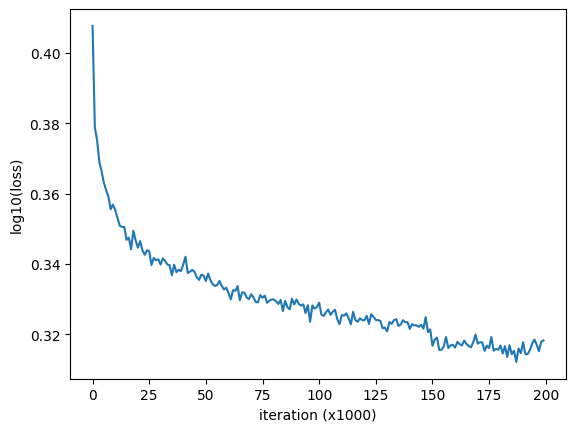

In [31]:
max_steps = 200000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (bs,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    logits = model(Xb)  # 32 x 27
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad  # type: ignore

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
# ------------------------------------------------------------

# Plot average loss
loss = torch.tensor(lossi).view(-1, 1000).mean(1)
plt.plot(loss)
plt.xlabel("iteration (x1000)")
plt.ylabel("log10(loss)")
plt.show()

#### Evaluation

In [32]:
# Put the model in evaluation model
for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.is_train = False  # type: ignore
# ------------------------------------------------------------


# Evaluate the model
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split) -> None:
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xval, Yval),
        "test": (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")
# ------------------------------------------------------------

# Generate some names
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    name = "".join(ix2ch[i] for i in out)
    print(f"exist: {name in names}  - {name:16s}")

train 2.0531623363494873
val 2.103024959564209
exist: False  - teliana.        
exist: False  - amris.          
exist: False  - kayon.          
exist: False  - chamarik.       
exist: False  - arlek.          
exist: False  - ferwlee.        
exist: False  - willen.         
exist: False  - ryla.           
exist: False  - jayke.          
exist: False  - kaydon.         
exist: False  - styarra.        
exist: False  - zave.           
exist: False  - wentley.        
exist: False  - rinai.          
exist: False  - khyle.          
exist: False  - laire.          
exist: False  - pavi.           
exist: False  - shaweethe.      
exist: False  - parzon.         
exist: False  - joriel.         


**Performance log**
- original (3 char context + 200 hidden neurons, 12K parameters): 2.103 train loss, 2.123 val loss.
- context 3->8 char (22K parameters): 2.072 train loss, 2.108 val loss.
- flat -> hierarchical (22K parameters): 2.053 train loss, 2.103 val loss.   
This tiny improvement is not significant. 